In [1]:
import pandas as pd
import numpy as np
import re 
from datetime import datetime, date, time
from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
path = "data/hh/"

In [21]:
#данные о ваканчсиях hh
col = ['name', 'description', 'key_skills']
train = pd.read_csv(path + 'vacancies_text.csv.zip', compression='zip')[col]
train.head(5)

,name,description,key_skills
0,Администратор торгового зала,Обязанности: Администратор торгового зала кон...,[]
1,Супервайзер команды Службы поддержки пользоват...,"В связи с расширением, в международной компани...",[]
2,Системный администратор,Для обеспечения технической поддержки объектов...,[]
3,Специалист по закупкам,Обязанности: Организация и проведение закупок...,"['Деловая переписка', 'Заключение договоров', ..."
4,Уборщик помещений / Уборщица,Ресторан O.D.I. приглашает на работу Уборщика ...,[]


In [22]:
train.shape

(2912650, 3)

In [1]:
#temp = train.sample(frac=0.001, replace=False, random_state=42, ignore_index=True) #n = 1000, weights='name'

target  
0 - обязанности  resp  или responsibilities(Должностные обязанности)   
1 - требования  req  или requirements(Требования к соискателю)  
2 - условия  cond  или terms(Условия)  

Разделим данные по заголовкам: обязанности, требования, условия. Что точно не определяется - выкидываем (в тест)

In [24]:
indxs = train.index.tolist()
names=[]
responsibilities=[]
requirements=[]
conditions=[]

test_names=[]
test_text=[] # неразмеченные

for idx in tqdm(indxs):
    name = train['name'][idx]
    text = train['description'][idx]
    skills = train['key_skills'][idx]    
    if len(re.findall("Обязанности:|Требования:|Условия:", text))==3:
        resp = ' '.join(re.findall(r'Обязанности:([^<>]+)Требования:', text))
        req = ' '.join(re.findall(r'Требования:([^<>]+)Условия:', text))
        cond = ' '.join(re.findall(r'Условия:([^<>]+)', text))
        
        names.append(name)
        pattern = r'\;|\.|- |\• '
        responsibilities.append([s.strip() for s in re.split(pattern, resp.lower()) if len(s.strip())>0])
        requirements.append([s.strip() for s in re.split(pattern, req.lower()) if len(s.strip())>0])
        conditions.append([s.strip() for s in re.split(pattern, cond.lower()) if len(s.strip())>0]) 
        
    else:
        test_names.append(name)
        test_text.append(text)   

  0%|          | 0/2912650 [00:00<?, ?it/s]

In [26]:
df_resp = pd.DataFrame({"names": names, "text": responsibilities}).explode('text')
df_resp['target']=0
df_resp.head(5)

,names,text,target
0,Администратор торгового зала,администратор торгового зала контролирует: те...,0
0,Администратор торгового зала,соблюдение технологической дисциплины в торгов...,0
0,Администратор торгового зала,"оформление торгового зала, полноту выкладки, р...",0
0,Администратор торгового зала,чистоту и порядок в торговом зале,0
0,Администратор торгового зала,"соблюдение деловой этики в общении, контроль в...",0


<AxesSubplot: ylabel='Frequency'>

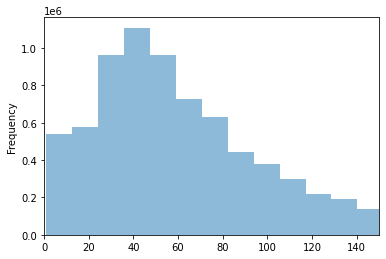

In [42]:
df_resp['text'].str.len().plot.hist(bins=500, alpha=0.5, xlim=(0, 150))

In [46]:
#удалим слишком длинные или короткие
df_resp = df_resp.loc[(df_resp['text'].str.len()>=20)&(df_resp['text'].str.len()<=80)]

In [47]:
df_req = pd.DataFrame({"names": names, "text": requirements}).explode('text')
df_req['target']=1
df_req.head(5)

,names,text,target
0,Администратор торгового зала,опыт работы с продуктами питания,1
0,Администратор торгового зала,ответственность,1
0,Администратор торгового зала,стрессоустойчивость,1
1,Специалист по закупкам,высшее образование (приоритет: юриспруденция и...,1
1,Специалист по закупкам,"быстрая обучаемость, внимательность, пунктуаль...",1


<AxesSubplot: ylabel='Frequency'>

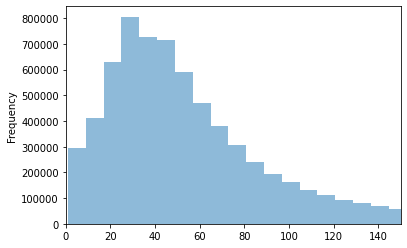

In [48]:
df_req['text'].str.len().plot.hist(bins=500, alpha=0.5, xlim=(0, 150))

In [49]:
#удалим слишком длинные или короткие
df_req = df_req.loc[(df_req['text'].str.len()>=20)&(df_req['text'].str.len()<=80)]

In [28]:
df_cond = pd.DataFrame({"names": names, "text": conditions}).explode('text')
df_cond['target']=2
df_cond.head(5)

,names,text,target
0,Администратор торгового зала,интересную и перспективную работу,2
0,Администратор торгового зала,дружный коллектив,2
0,Администратор торгового зала,обучение и карьерный рост,2
0,Администратор торгового зала,скидки на продукцию магазина,2
0,Администратор торгового зала,оплачиваемый отпуск и другие социальные гарант...,2


<AxesSubplot: ylabel='Frequency'>

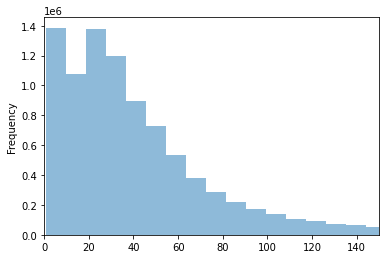

In [50]:
df_cond['text'].str.len().plot.hist(bins=500, alpha=0.5, xlim=(0, 150))

In [51]:
#удалим слишком длинные или короткие
df_cond = df_cond.loc[(df_cond['text'].str.len()>=10)&(df_cond['text'].str.len()<=50)]

In [52]:
df_train = pd.concat([df_resp, df_req, df_cond], axis=0, ignore_index=True)
#df_train.dropna(subset=['names', 'text'], inplace=True) #, ignore_index=True
df_train.dropna(subset=['text'], inplace=True) 
df_train.head(5)

,names,text,target
0,Администратор торгового зала,чистоту и порядок в торговом зале,0
1,Администратор торгового зала,"соблюдение деловой этики в общении, контроль в...",0
2,Администратор торгового зала,обеспечивает организацию работ представителей ...,0
3,Специалист по закупкам,организация и проведение закупок в рамках 223-...,0
4,Специалист по закупкам,"формирование месячной/годовой отчетности, разм...",0


In [30]:
#тест не делим на предложения
df_test = pd.DataFrame({"names": test_names, "text": test_text}).explode('text')
df_test.dropna(subset=['names', 'text'], inplace=True) 
df_test.head(5)

,names,text
0,Супервайзер команды Службы поддержки пользоват...,"В связи с расширением, в международной компани..."
1,Системный администратор,Для обеспечения технической поддержки объектов...
2,Прораб (фасадные работы),Должностные обязанности: - руководство бригада...
3,Administrative assistant,Responsibilities: Maintaining the condition o...
4,Машинист экскаватора,Строительная организация приглашает на работу ...


In [53]:
#df_train['text'].str.len().median(), df_train['text'].str.len().mean()

Сохраненение

In [54]:
filename = 'df_train'
compression_options = dict(method='zip', archive_name=f'{filename}.csv')
df_train.to_csv(f'data/{filename}.zip', compression=compression_options, index=False)

In [221]:
filename = 'df_test'
compression_options = dict(method='zip', archive_name=f'{filename}.csv')
df_test.to_csv(f'data/{filename}.zip', compression=compression_options, index=False)

База вакансий компании

In [73]:
data = pd.read_excel(open('роскапстрой.xlsx', 'rb'), index_col=None, sheet_name='Лист1')
data.head()

,id,name,Зарплата,Требуемый опыт работы,Занятость,Обязанности,Требования,Условия,Ключевые навыки
0,РосКапСтрой,Ведущий инженер строительного контроля\n,до 133 000 руб. до вычета налогов,более 6 лет,"Полная занятость, полный день",проведение контрольных мероприятий в рамках ст...,высшее строительное образование;\nболее 5 лет ...,работа в Федеральном автономном учреждении Мин...,NaN
1,РосКапСтрой,"Инженер-геодезист (Улан-Удэ, Якутск, Тамбов, М...",до 133 000 руб. до вычета налогов,3–6 лет,"Полная занятость, полный день","Организация подготовки, планирования и контрол...",Высшее образование (Инженер - Геодезист);\nЗна...,работа в Федеральном автономном учреждении Мин...,NaN
2,РосКапСтрой,Инженер ПТО,от 70 000 руб. до вычета налогов,1–3 года,"Полная занятость, полный день","Приёмка от Заказчика проектной, рабочей и разр...",Образование: Высшие техническое.\nЗнание техно...,Работа в Федеральном автономном учреждении «Ро...,NaN
3,РосКапСтрой,Инженер-геодезист,NaN,3–6 лет,"Полная занятость, полный день","Организация подготовки, планирования и контрол...",Высшее образование (Инженер - Геодезист);\nПра...,Оформление в полном соответствии с ТК РФ;\nГра...,NaN
4,РосКапСтрой,Руководитель конструкторской группы,от 150 000 руб. до вычета налогов,более 6 лет,"Полная занятость, полный день",руководство проектно-конструкторскими работами...,высшее профильное образование;\nопыт работы по...,работа в Федеральном автономном учреждении Мин...,NaN


In [74]:
df = data[['name', 'Зарплата', 'Требуемый опыт работы', 'Занятость']].copy()
df['Комментарии']=''

In [80]:
def list_unit(text):
    try:
        #sentences = re.compile(r'\;|\.|\n|\•|—').split(text.lower()) 
        #return [s.strip() for s in sentences if len(s)>0]
        pattern = r'^[^а-яА-ЯёЁ]+|[^а-яА-ЯёЁ]+$'
        sentences = text.lower().split("\n")
        return[re.sub(pattern, '', sen) for sen in sentences if len(sen)>0]
    except:
        return []

In [81]:
#datetime.now().strftime('%Y-%m-%d %I:%M%p')

In [82]:
df['Обязанности'] = data['Обязанности'].apply(lambda x: list_unit(x))
df['Требования'] = data['Требования'].apply(lambda x: list_unit(x))
df['Условия'] = data['Условия'].apply(lambda x: list_unit(x))
df['Дата создания']=datetime.now().strftime('%Y-%m-%d %H:%M:%S')
df.index.name = 'ID вакансии'

In [83]:
df

,name,Зарплата,Требуемый опыт работы,Занятость,Комментарии,Обязанности,Требования,Условия,Дата создания
ID вакансии,,,,,,,,,
0,Ведущий инженер строительного контроля\n,до 133 000 руб. до вычета налогов,более 6 лет,"Полная занятость, полный день",,[проведение контрольных мероприятий в рамках с...,"[высшее строительное образование, более 5 лет ...",[работа в федеральном автономном учреждении ми...,2023-06-22 21:03:04
1,"Инженер-геодезист (Улан-Удэ, Якутск, Тамбов, М...",до 133 000 руб. до вычета налогов,3–6 лет,"Полная занятость, полный день",,"[организация подготовки, планирования и контро...","[высшее образование (инженер - геодезист, знан...",[работа в федеральном автономном учреждении ми...,2023-06-22 21:03:04
2,Инженер ПТО,от 70 000 руб. до вычета налогов,1–3 года,"Полная занятость, полный день",,"[приёмка от заказчика проектной, рабочей и раз...","[образование: высшие техническое, знание техно...",[работа в федеральном автономном учреждении «р...,2023-06-22 21:03:04
3,Инженер-геодезист,NaN,3–6 лет,"Полная занятость, полный день",,"[организация подготовки, планирования и контро...","[высшее образование (инженер - геодезист, прак...","[оформление в полном соответствии с тк рф, гра...",2023-06-22 21:03:04
4,Руководитель конструкторской группы,от 150 000 руб. до вычета налогов,более 6 лет,"Полная занятость, полный день",,[руководство проектно-конструкторскими работам...,"[высшее профильное образование, опыт работы по...",[работа в федеральном автономном учреждении ми...,2023-06-22 21:03:04
5,Архитектор,от 130 000 руб. до вычета налогов,3–6 лет,"Полная занятость, полный день",,[проведение необходимых для разработки архитек...,"[высшее профильное образование, опыт работы от...",[работа в федеральном автономном учреждении ми...,2023-06-22 21:03:04
6,Ведущий инженер-конструктор,от 130 000 руб. до вычета налогов,3–6 лет,"Полная занятость, полный день",,[разработка чертежей строительных конструкций ...,"[высшее профильное образование, опыт работы от...",[работа в федеральном автономном учреждении ми...,2023-06-22 21:03:04
7,Ведущий инженер ПТО (Симферополь),от 88 000 руб. на руки,3–6 лет,"Полная занятость, полный день",,[оформление исполнительной документации на инж...,"[опыт работы по инженерные сети (разделы вв, в...","[кандидаты, готовые к переезду в республику кр...",2023-06-22 21:03:04
8,Ведущий инженер ПТО (Симферополь),от 88 000 руб. на руки,3–6 лет,"Полная занятость, полный день",,[оформление исполнительной документации на инж...,"[опыт работы по инженерные сети (разделы вв, в...","[кандидаты, готовые к переезду в республику кр...",2023-06-22 21:03:04


In [72]:
df.to_csv('temp.csv', index=True)

In [49]:
data = pd.read_csv('job-text-processing/data/temp.csv', index_col=None)

In [50]:
temp=data.iloc[0]
temp

ID вакансии                                                              0
name                              Ведущий инженер строительного контроля\n
Зарплата                                 до 133 000 руб. до вычета налогов
Требуемый опыт работы                                          более 6 лет
Занятость                                    Полная занятость, полный день
Комментарии                                                            NaN
Обязанности              ['проведение контрольных мероприятий в рамках ...
Требования               ['высшее строительное образование', 'более 5 л...
Условия                  ['работа в федеральном автономном учреждении м...
Дата создания                                          2023-06-22 12:08:24
Name: 0, dtype: object

In [53]:
temp['Требования']

"['высшее строительное образование', 'более 5 лет в должности инженера строительного контроля', 'стаж в строительстве от 10 лет,', 'знание строительных норм и правил, действующего градостроительного законодательства', 'уверенный пользователь пк', 'готовность к работе в информационно-аналитической системе']"